In [268]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('russian')
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

from collections import Counter

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

Датасет я решил взять готовый, вот отсюда:

https://habr.com/ru/post/467081/

В нем также был выделен нейтральный класс, поэтому его пришлось удалить.

In [31]:
reviews_positive_path = 'reviews/positive'
reviews_positive = []
for i in os.listdir(reviews_positive_path):
    with open(os.path.join(reviews_positive_path, i), encoding='utf-8') as f:
        text = f.read()
        reviews_positive.append(text)  

In [32]:
len(reviews_positive)

1001

In [35]:
reviews_negative_path = 'reviews/negative'
reviews_negative = []
for i in os.listdir(reviews_negative_path):
    with open(os.path.join(reviews_negative_path, i), encoding='utf-8') as f:
        text = f.read()
        reviews_negative.append(text)  

In [36]:
len(reviews_negative)

999

In [41]:
positive = pd.DataFrame(reviews_positive, columns=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.DataFrame(reviews_negative, columns=['text'])
negative['label'] = ['negative'] * len(negative)
reviews_df = positive.append(negative)
reviews_df

,text,label
0,"Данное кино я не смотрел в кинотеатре, хотя бы...",positive
1,"«Сказка быль, да в ней намек». Обычно так зака...",positive
2,Подошел к концу самый масштабный сериал в исто...,positive
3,"Киновселенная 'DC', ещё очень молода и только-...",positive
4,На самом ли деле сон - это лишь субъективное в...,positive
...,...,...
994,"Вот именно, что это? Комедия? Тогда где смеять...",negative
995,"Фильм «Игры разума» Рона Ховарда, режиссера на...",negative
996,"Это моя первая рецензия, которую меня побудило...",negative
997,"Если Вам нравился первый фильм Форсаж, то можн...",negative


In [171]:
train = reviews_df.sample(frac=0.75, random_state=42)
test = reviews_df.drop(train.index)

X_train = train['text']
X_test = test['text']
y_train = train['label']
y_test = test['label']

In [172]:
X_train

859    В 90-х и начале нулевый Кевин Смит снимал отли...
353    Созерцать сие кино, не подключая скрытые эмоци...
332    Ох сходил я буквально прошлым вечером на это '...
905    Warning funs! Хочу начать эту рецензию с таких...
288    Ужасный фильм. Плохо с чувством юмора, плохо с...
                             ...                        
773    Маэстро Тарантино вновь на большом экране. Оче...
218    Сколько можно уже штамповать отвратительный шл...
998    Фильм перенесёт нас в 1963 год в США, во време...
4      На самом ли деле сон - это лишь субъективное в...
2      Ну наконец-то мне выпала уникальная возможност...
Name: text, Length: 1500, dtype: object

In [173]:
def preprocess_review(text):
    text = [w.lower() for w in word_tokenize(text) if w.isalpha() and (w not in STOPWORDS)]
    text = [morph.parse(w)[0].normal_form for w in text]
    text = [w for w in text if w not in STOPWORDS]
    
    return text

In [174]:
%%time

positive_preprocess = reviews_df[reviews_df['label'] == 'positive']['text'].apply(preprocess_review)
negative_preprocess = reviews_df[reviews_df['label'] == 'negative']['text'].apply(preprocess_review)

Wall time: 1min 7s


In [175]:
reviews_df[reviews_df['label'] == 'positive']

,text,label
0,"Данное кино я не смотрел в кинотеатре, хотя бы...",positive
1,"«Сказка быль, да в ней намек». Обычно так зака...",positive
2,Подошел к концу самый масштабный сериал в исто...,positive
3,"Киновселенная 'DC', ещё очень молода и только-...",positive
4,На самом ли деле сон - это лишь субъективное в...,positive
...,...,...
996,"Эй, моряк, ты слишком долго плавал,\n\n\nЯ теб...",positive
997,Анонс выхода на экраны седьмой части экшн-фран...,positive
998,"Что же такое 'Начало'? Фильм-шедевр, фильм-фен...",positive
999,"Признаться честно, мне стыдно! Стыдно, за то ч...",positive


In [176]:
positive_words = [w for t in positive_preprocess for w in t]
negative_words = [w for t in negative_preprocess for w in t]

In [177]:
len(positive_words)

236691

In [178]:
len(negative_words)

214746

In [179]:
positive_keywords = dict(Counter(positive_words))
negative_keywords = dict(Counter(negative_words))

In [180]:
'нас' in negative_keywords #проверяем, что стоп-слова во всех падежах отфильтрованы

False

In [181]:
def filter_keywords(keywords, threshold=1):
    keywords = [k for k in keywords if keywords[k] >= threshold]
    keywords = set(keywords)
    
    return keywords

In [182]:
positive_keywords = filter_keywords(positive_keywords)
negative_keywords = filter_keywords(negative_keywords)

In [183]:
len(positive_keywords)

19415

In [184]:
len(negative_keywords)

20597

In [185]:
intersection = positive_keywords & negative_keywords
positive_keywords -= intersection
negative_keywords -= intersection

In [186]:
len(positive_keywords)

6939

In [187]:
len(negative_keywords)

8121

In [255]:
def vectorize_dataset(dataset):
    def vectorize_review(text):
        text = set(preprocess_review(text))
        positive_count = 0
        negative_count = 0

        for word in text:
            if word in positive_keywords:
                positive_count += 1
            elif word in negative_keywords:
                negative_count += 1

        return positive_count, negative_count
    
    dataset = [vectorize_review(t) for t in dataset]
    dataset = np.vstack(dataset)
    
    return dataset

In [271]:
%%time

X_train_vectorized = vectorize_dataset(X_train)
X_test_vectorized = vectorize_dataset(X_test)

Wall time: 52.7 s


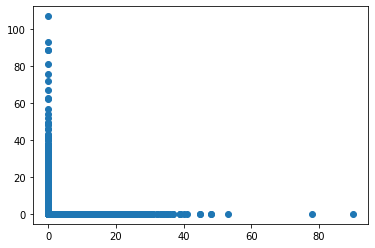

In [307]:
# Визуализируем отзывы в двух измерениях - количество строго положительных и строго отрицательных слов
plt.scatter(X_train_vectorized[:, 0], X_train_vectorized[:, 1])
plt.show()
# Очевидно, что в обучающей выборке нет таких отзывов, в которых встречаются и строго положительные, и строго отрицательные
# слова. Однако мы не можем гарантировать, что таких отзывов не будет и в тестовой выборке

In [300]:
def accuracy(pred, true):
    metric = (pred == true)
    metric = len(metric[metric == True]) / len(true)
    
    return metric

In [310]:
%%time

LR = LogisticRegression()
LR.fit(X_train_vectorized, y_train)

Wall time: 2.96 ms


c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [311]:
accuracy(LR.predict(X_test_vectorized), y_test)

0.990909090909091

Некоторые улучшающие мульки я уже добавил: работа с массивами numpy должна быть быстрее, чем со списками, а логистическая регрессия добавляет веса количеству строго положительных и строго отрицательных слов, которые встречаются в текстах. Это может быть нужно для того, чтобы учесть ситуацию, когда в тестовой выборке появятся тексты, в которых будут перемешаны строго положительные и строго отрицательные слова.
Кроме того, можно улучшить эту программу, сделав классификацию на эмбеддингах. Тогда мы не будем настолько привязаны к распределению строго положительных и строго отрицательных слов из обучающей выборки.